## Team 7: Online News Popularity

In [1]:
# Import Libaries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp

warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook, tnrange
tqdm_notebook().pandas()

# Define Graph Styles
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
d_fontsize = 20
d_figsize = (20,8)
sns.set(rc={'figure.figsize': d_figsize})
target_name = 'Number of Shares'

# Load Data as DataFrame
csv_path = './datasets/OnlineNewsPopularity.csv'
df = pd.read_csv(csv_path)

C:\Users\Qinfang\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


<div class="alert alert-info" style="font-size:150%"><b>1. Clean Data</b></div>

In [2]:
# Remove Weird Spaces From Column Names
df.columns = df.columns.map(lambda x: x.replace(' ', ''))

In [3]:
# Convert Columns to Correct Data Types
boolean_columns = [column_name for column_name in df.columns if 'is' in column_name]
df[boolean_columns] = df[boolean_columns].astype(bool)

'''
['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend']
 '''

int_columns = [
    'timedelta', # Days between the article publication and the dataset acquisition
    'n_tokens_title', # Number of words in the title
    'n_tokens_content', # Number of words in the content
    'num_hrefs', # Number of links
    'num_self_hrefs', # Number of links to other articles
    'num_imgs', # Number of images
    'num_videos', # Number of videos
    'num_keywords', # Number of keywords in the metadata
    'self_reference_min_shares', # Min. shares of referenced articles in Mashable
    'self_reference_max_shares', # Max. shares of referenced articles in Mashable
]

df[int_columns] = df[int_columns].astype('int64')

<div class="alert alert-info" style="font-size:150%"><b>2. EDA</b></div>

In [4]:
print('There are {num_articles} articles'.format(num_articles = len(df)))

There are 39644 articles


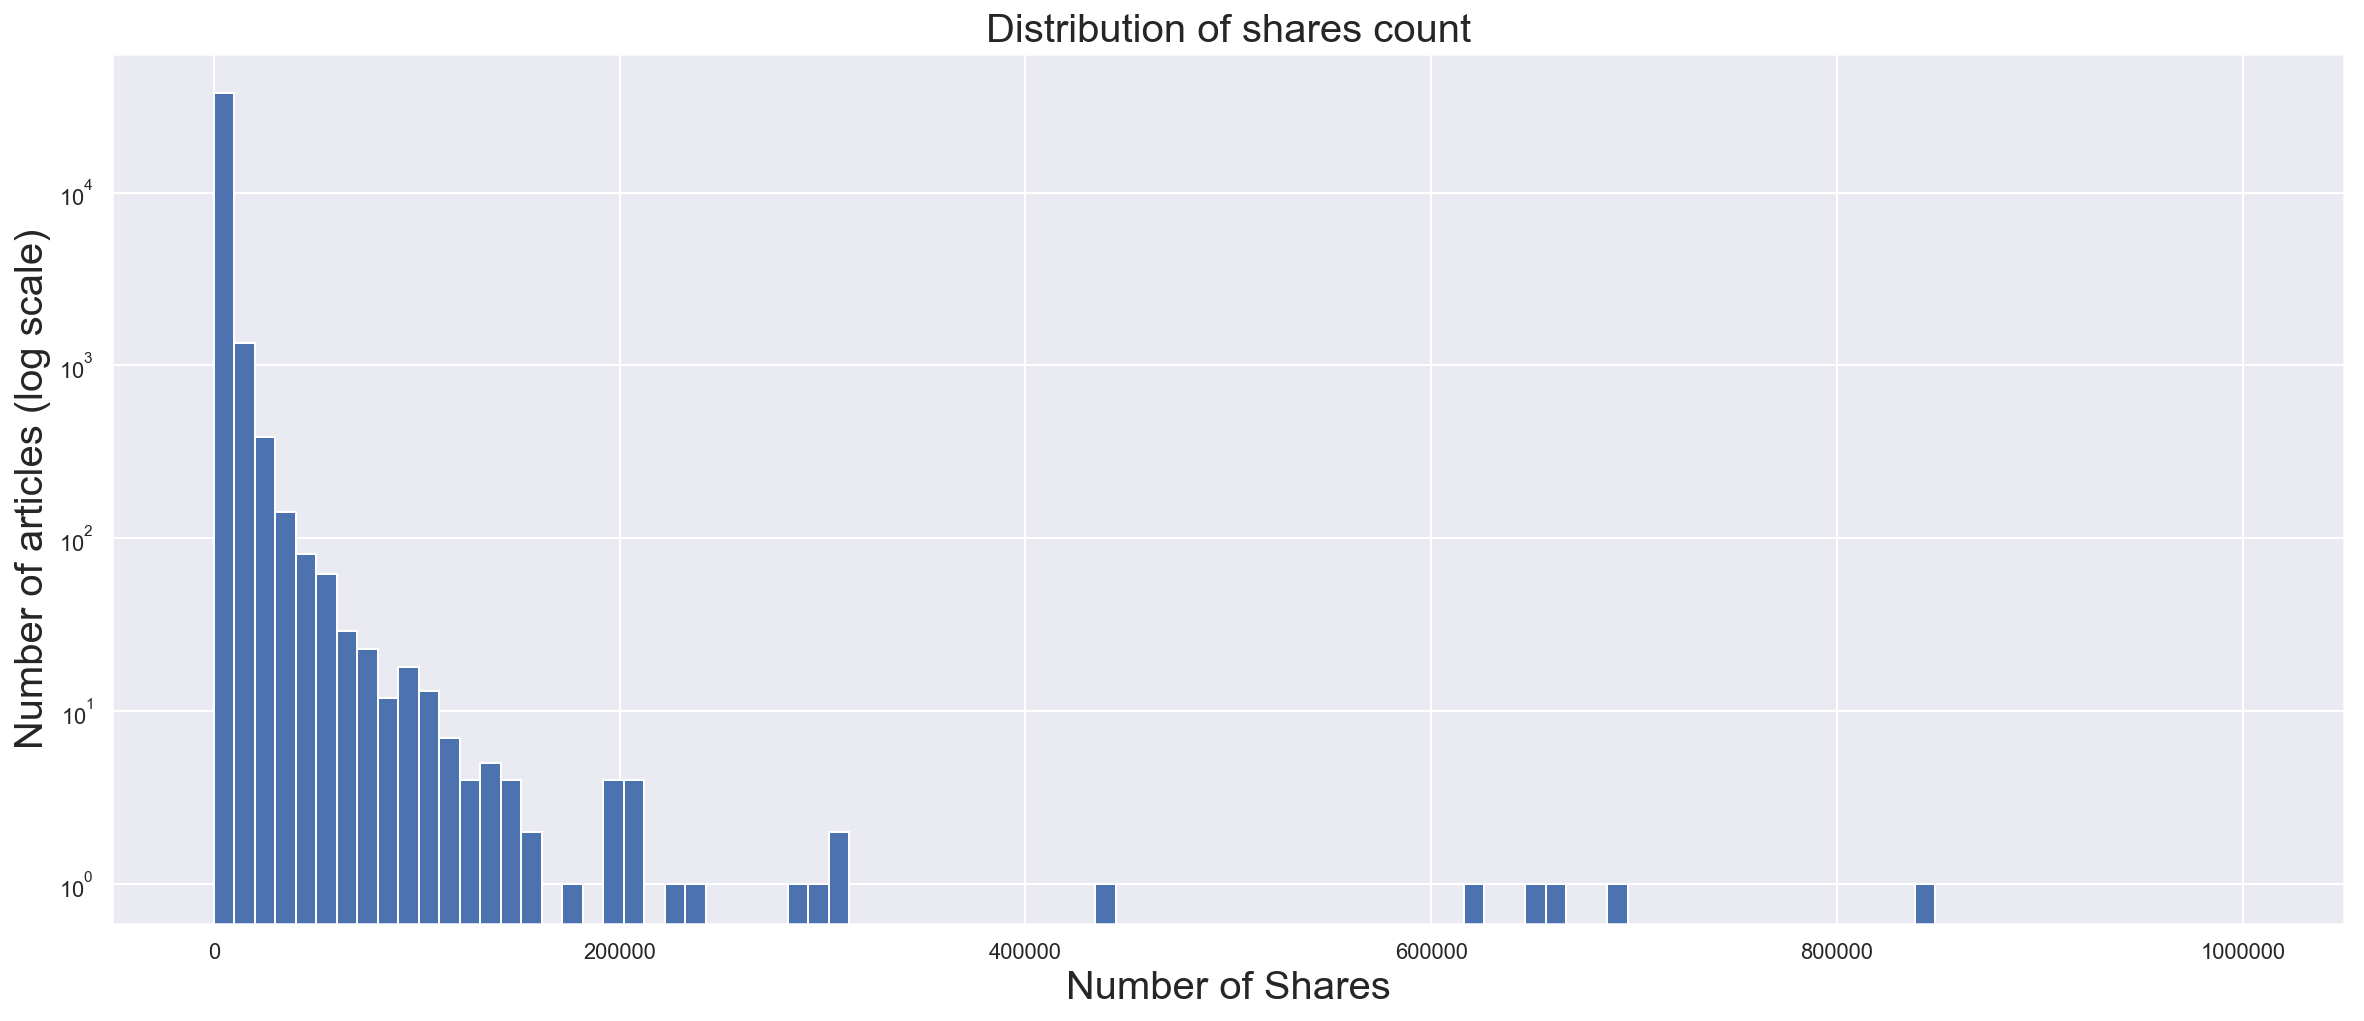

In [5]:
def plot_distribution_of_target_variable():
    plot_data = df['shares']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_yscale('log')
    ax.set_title('Distribution of shares count', fontsize = d_fontsize)
    ax.set_xlabel(target_name, fontsize = d_fontsize)
    ax.set_ylabel('Number of articles (log scale)', fontsize = d_fontsize)
    ax.hist(plot_data, bins = np.linspace(0, 10**6, 10**2));
plot_distribution_of_target_variable()

<div class="alert alert-info" style="font-size:150%">Even with y-axis on log scale, distribution of shares count is still extremely skewed to the right. Thus, we create alternative target variables: <b>target_p50</b>, <b>target_p90</b> and <b>target_categories</b>.</div>

In [6]:
shares_p50 = df['shares'].quantile(0.5)
shares_p50

1400.0

<div class="alert alert-info" style="font-size:150%"><b>target_p50</b>: Instead of predicting share count, we predict whether an article will go viral, with the defintion of viral being more than 1400 shares (50th percentile)</div>

In [7]:
df['target_p50'] = df['shares'].map(lambda x : 1 if x > shares_p50 else 0)
df[['shares', 'target_p50']].head()

,shares,target_p50
0,593,0
1,711,0
2,1500,1
3,1200,0
4,505,0


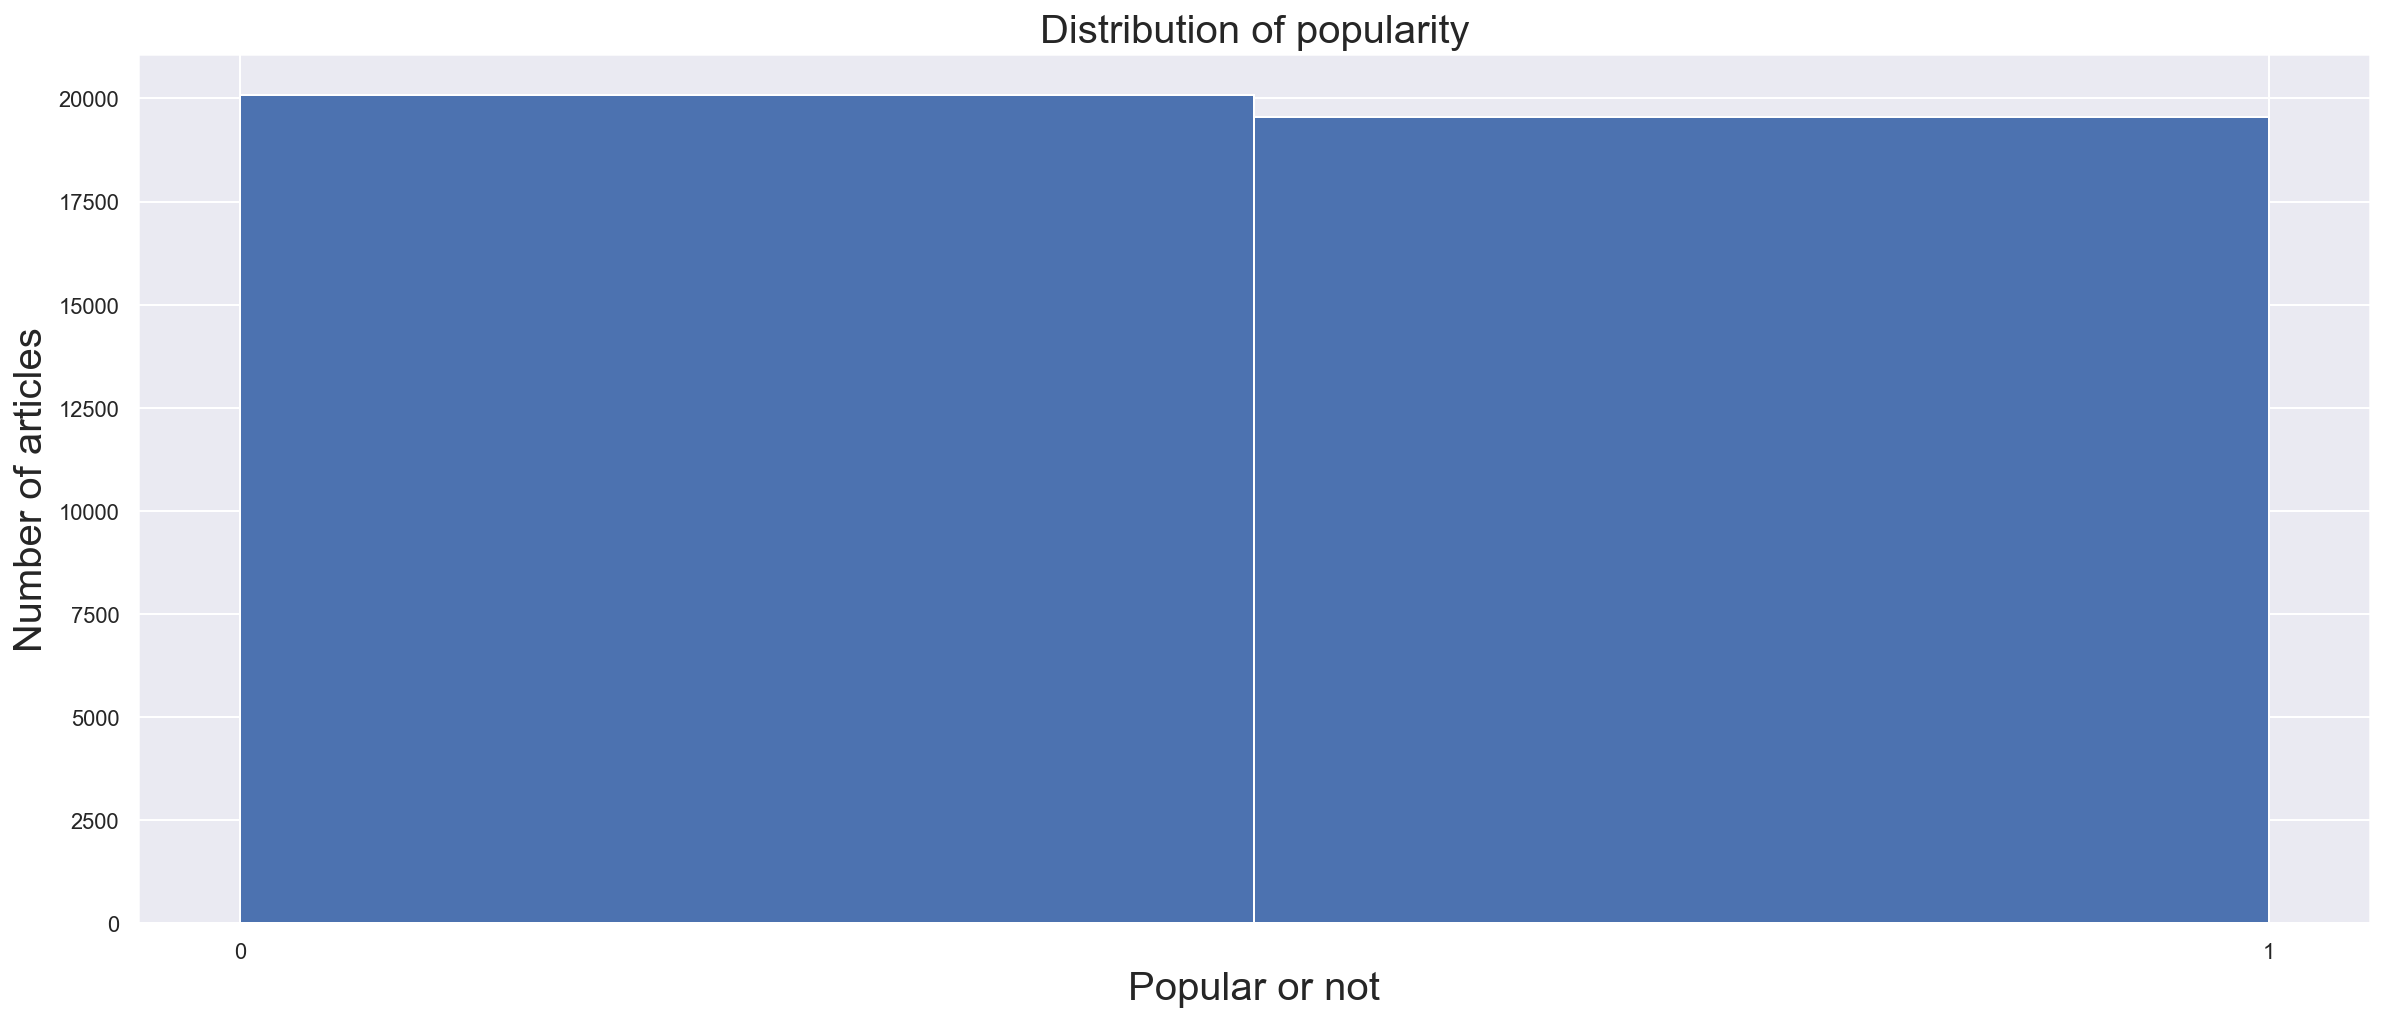

In [8]:
def plot_pop_distribution():
    plot_data = df['target_p50']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of popularity', fontsize = d_fontsize)
    ax.set_xlabel('Popular or not', fontsize = d_fontsize)
    ax.set_xticks([0,1])
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=2);
plot_pop_distribution()

In [9]:
shares_p90 = df['shares'].quantile(0.9)
shares_p90

6200.0

<div class="alert alert-info" style="font-size:150%"><b>target_p90</b>: Instead of predicting share count, we predict whether an article will go viral, with the defintion of viral being more than 6200 shares (90th percentile)</div>

In [10]:
df['target_p90'] = df['shares'].map(lambda x : 1 if x > shares_p90 else 0)
df[['shares', 'target_p90']].head()

,shares,target_p90
0,593,0
1,711,0
2,1500,0
3,1200,0
4,505,0


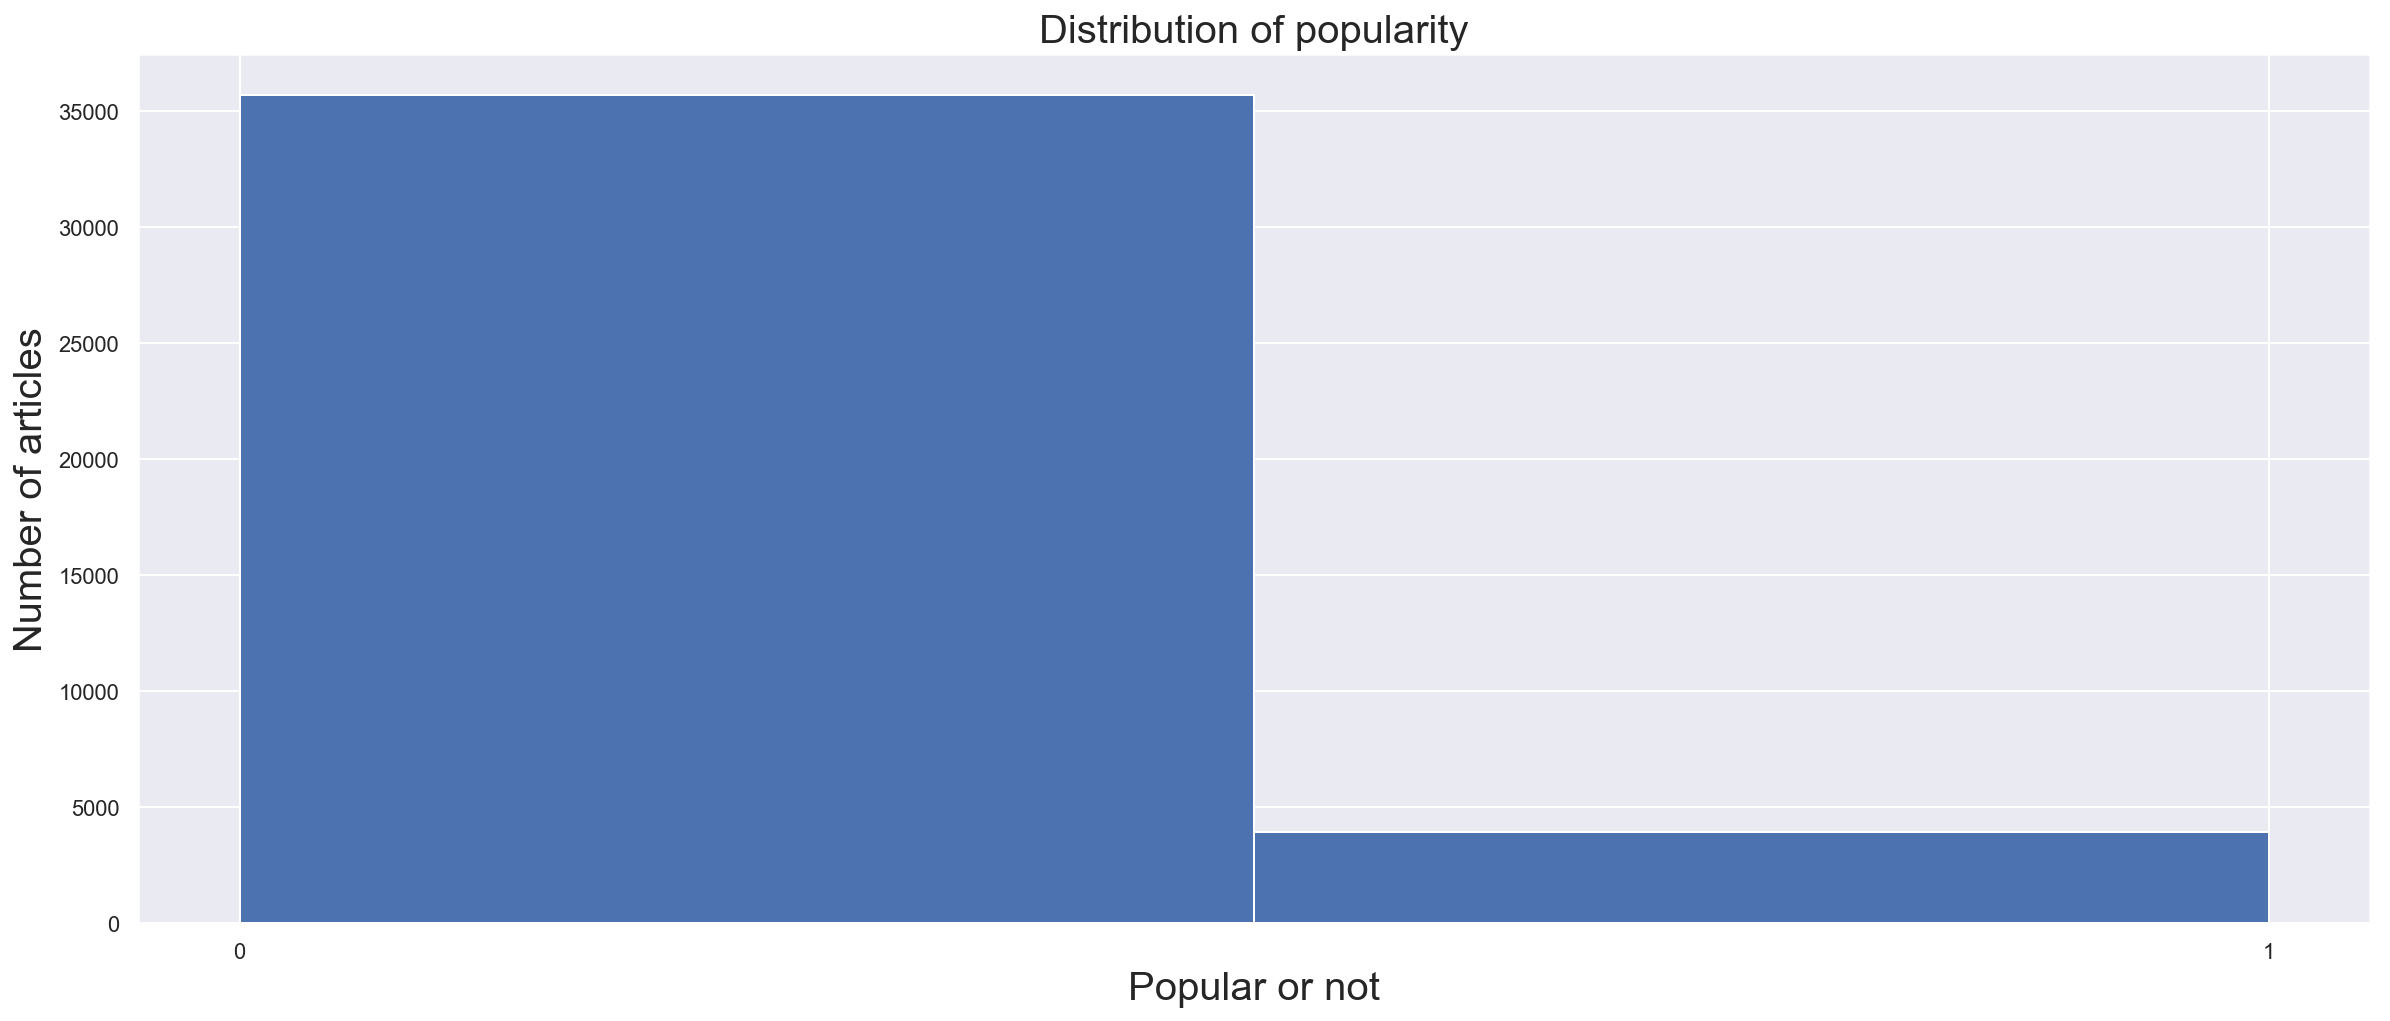

In [11]:
def plot_pop_distribution():
    plot_data = df['target_p90']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of popularity', fontsize = d_fontsize)
    ax.set_xlabel('Popular or not', fontsize = d_fontsize)
    ax.set_xticks([0,1])
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=2);
plot_pop_distribution()

<div class="alert alert-info" style="font-size:150%"><b>target_categories</b>: Instead of predicting share count, we predict whether an article's share count will be within the 1st - 25th percentile, 25th - 50th percentile, 50th - 75th percentile of 75th - 99th percentile.</div>

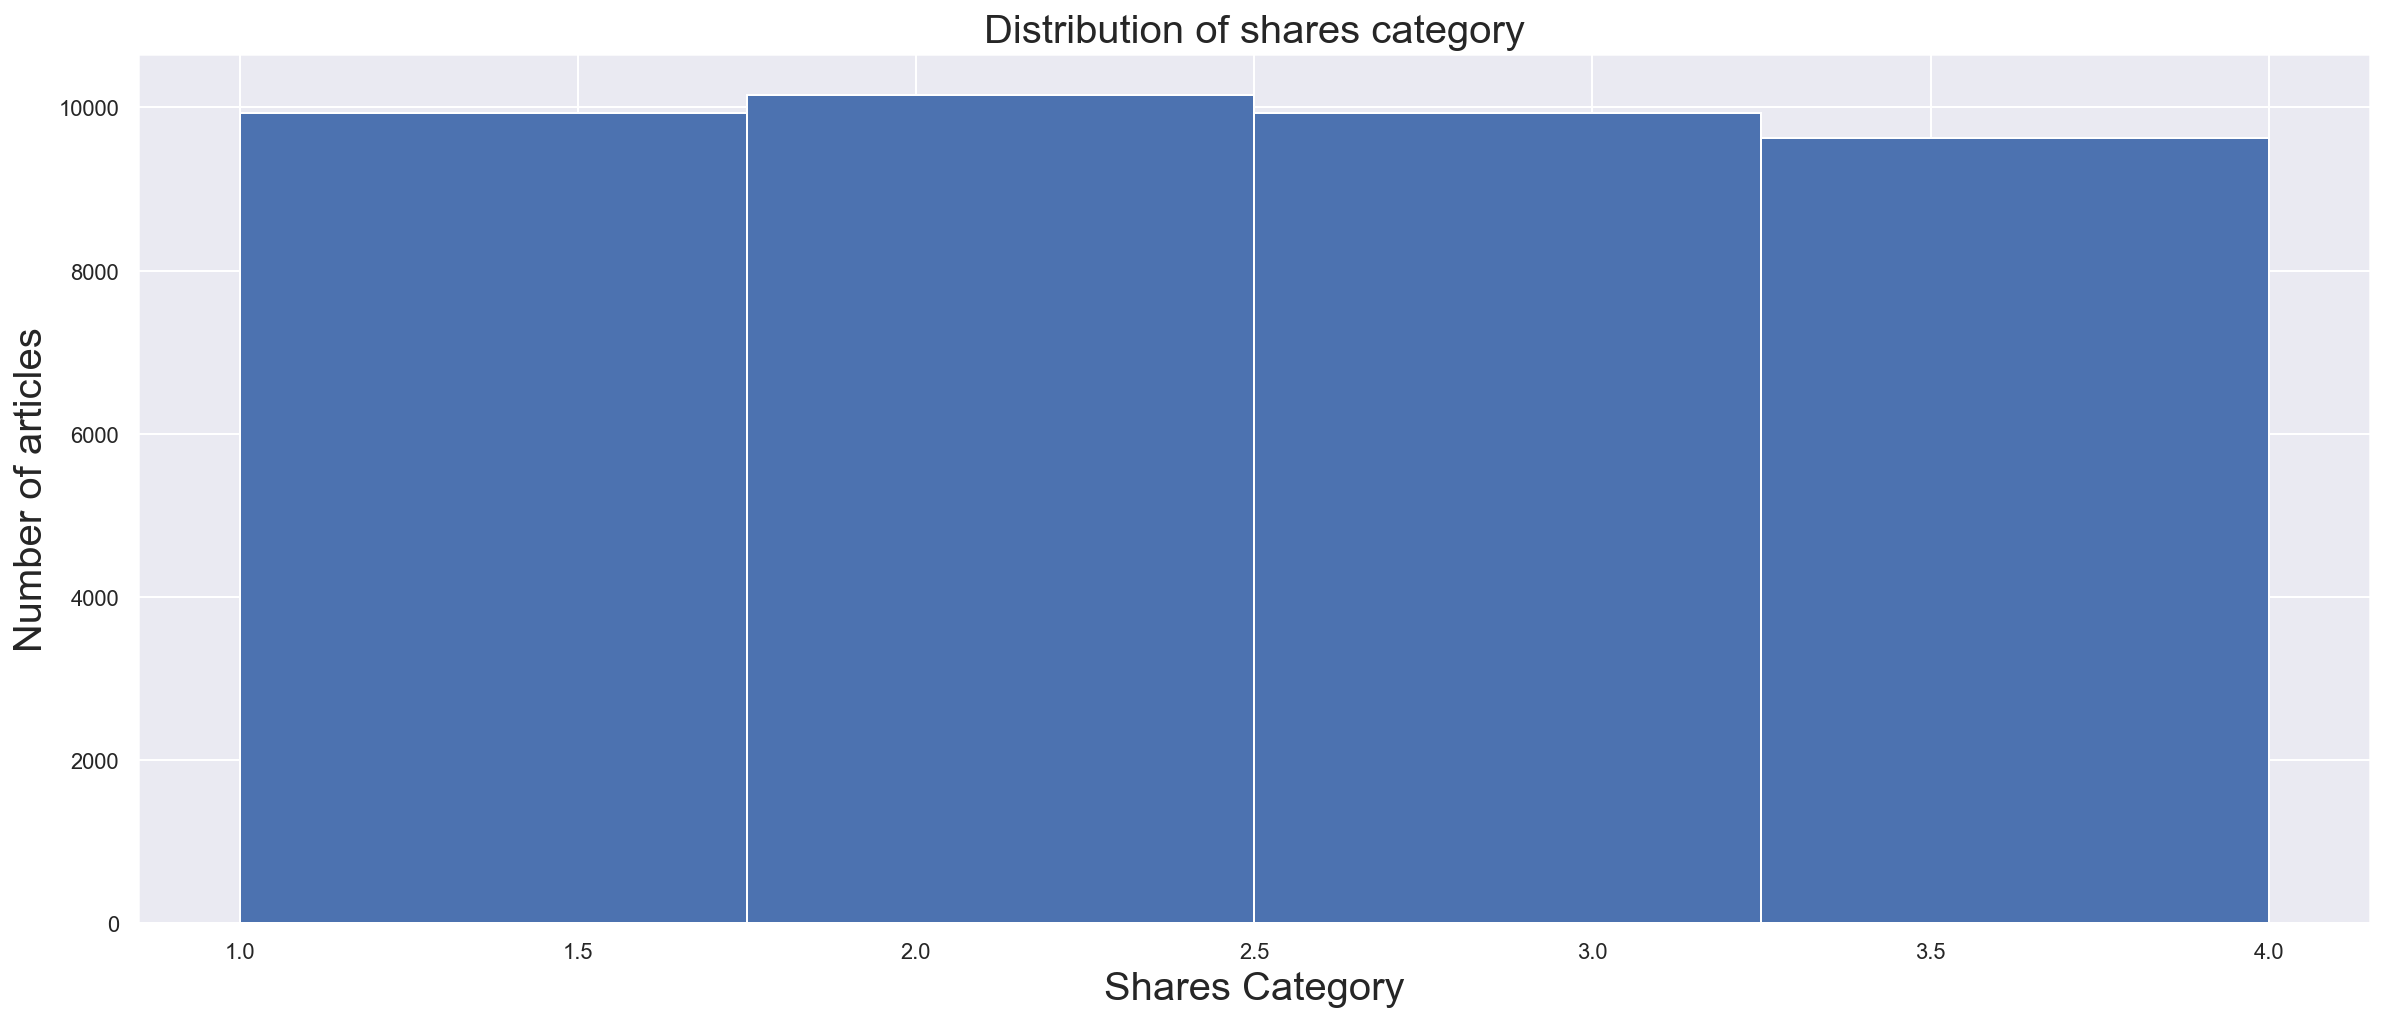

In [12]:
p_25 = df['shares'].quantile(0.25)
p_50 = df['shares'].quantile(0.50)
p_75 = df['shares'].quantile(0.75)
df['target_categories'] = df['shares'].apply(lambda x: 4 if x > p_75 else (3 if x > p_50 else (2 if x > p_25 else 1)))
def plot_shares_cat_distribution():
    plot_data = df['target_categories']
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_title('Distribution of shares category', fontsize = d_fontsize)
    ax.set_xlabel('Shares Category', fontsize = d_fontsize)
    ax.set_ylabel('Number of articles', fontsize = d_fontsize)
    ax.hist(plot_data, bins=4);
plot_shares_cat_distribution()

<div class="alert alert-info" style="font-size:150%"><b>3. Correlation with Target</b></div>

In [13]:
# linear correlation
df_without_y = df[[x for x in df.columns if x not in ['target_categories', 'target_p50', 'target_p90']]]
top_correlated = df_without_y.corr(method = 'spearman')['shares'].abs().sort_values()[::-1]
predictors_t5 = list(top_correlated[1:6].keys())
predictors_t10 = list(top_correlated[1:11].keys())
predictors_all = list(top_correlated[1::].keys())

predictors_t5

['kw_avg_avg',
 'kw_max_avg',
 'self_reference_avg_sharess',
 'self_reference_min_shares',
 'self_reference_max_shares']

<div class="alert alert-info" style="font-size:150%">These are the top 5 predictor variables with strong linear correlation. </div>

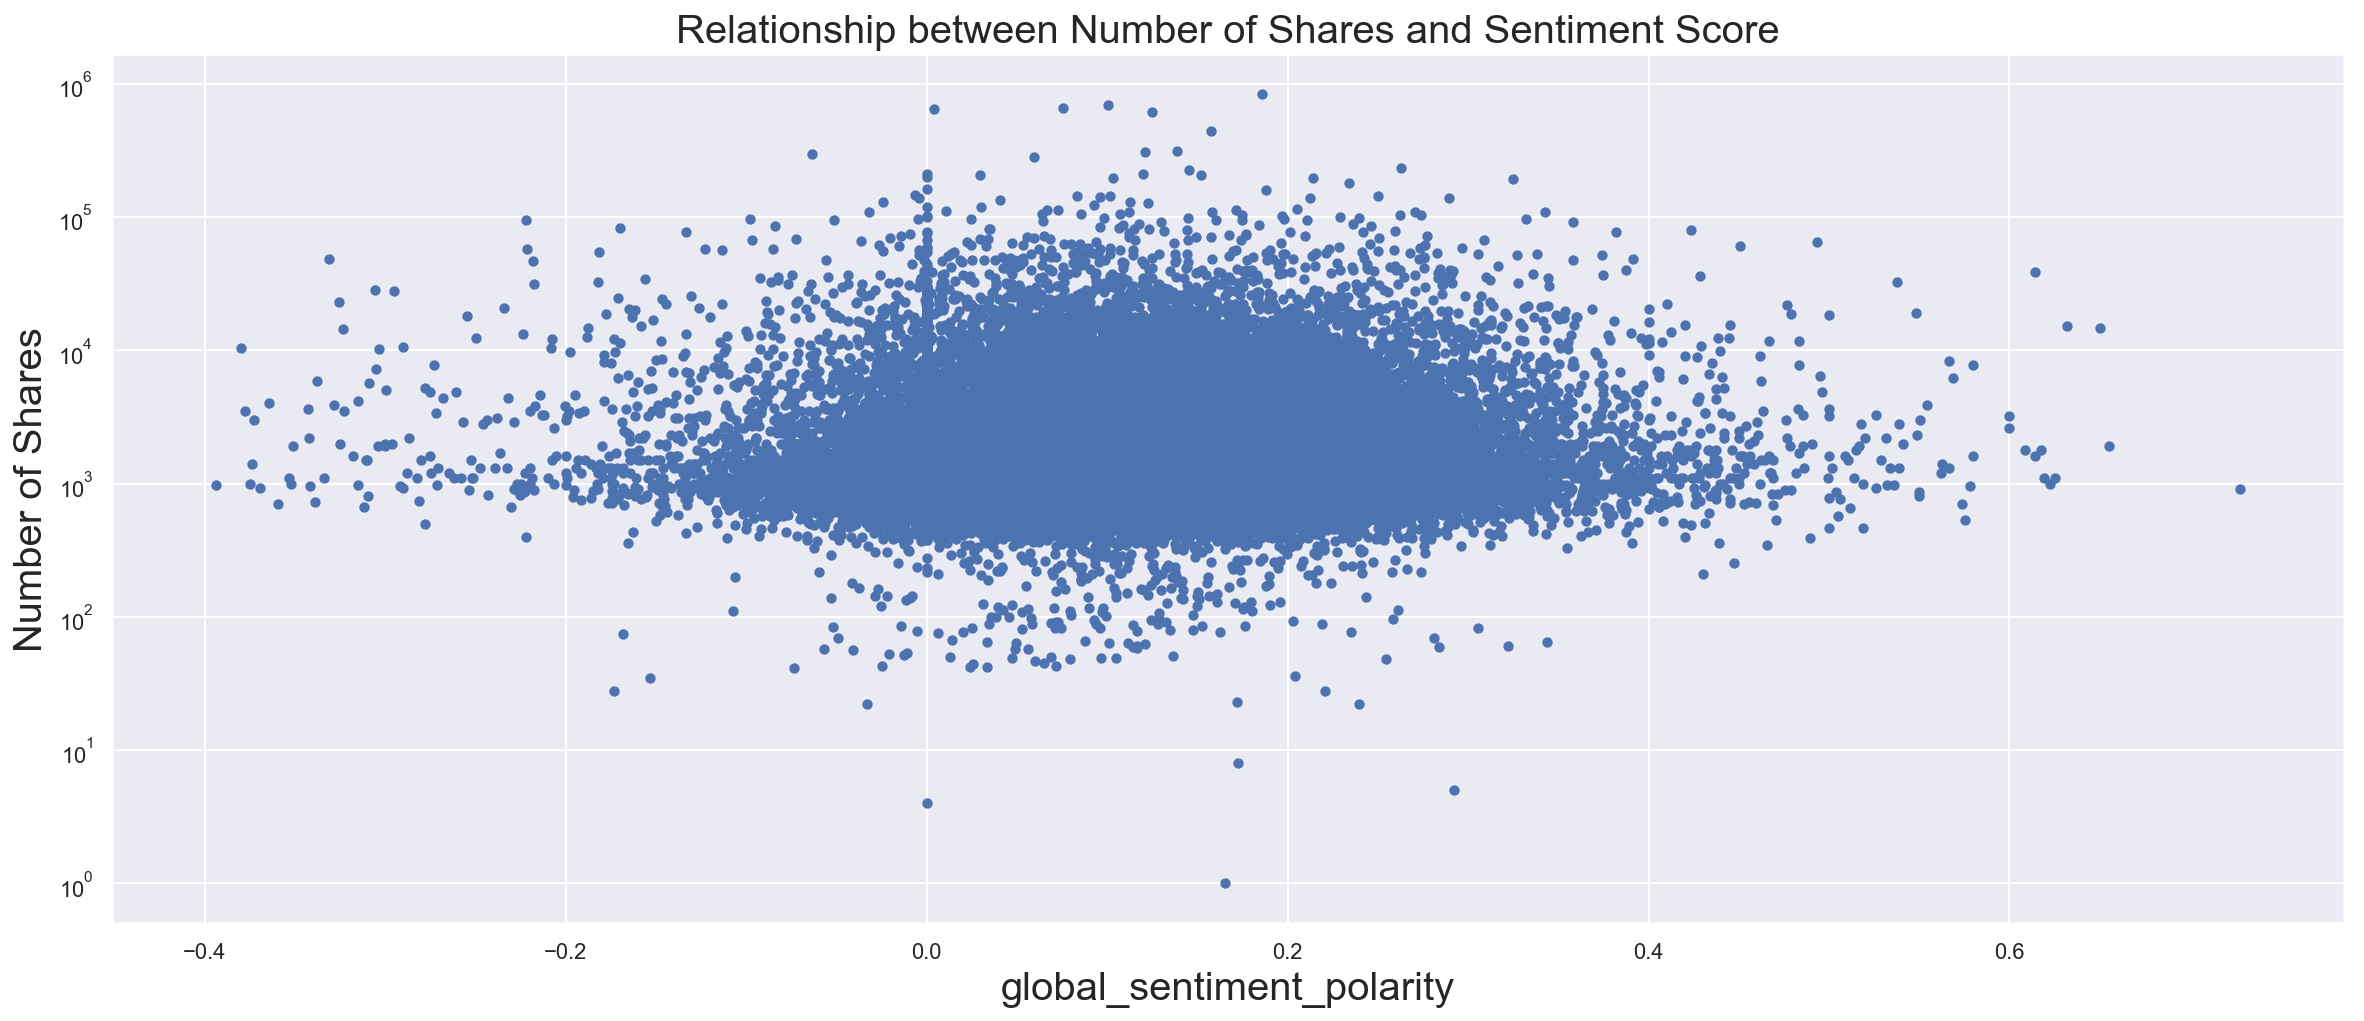

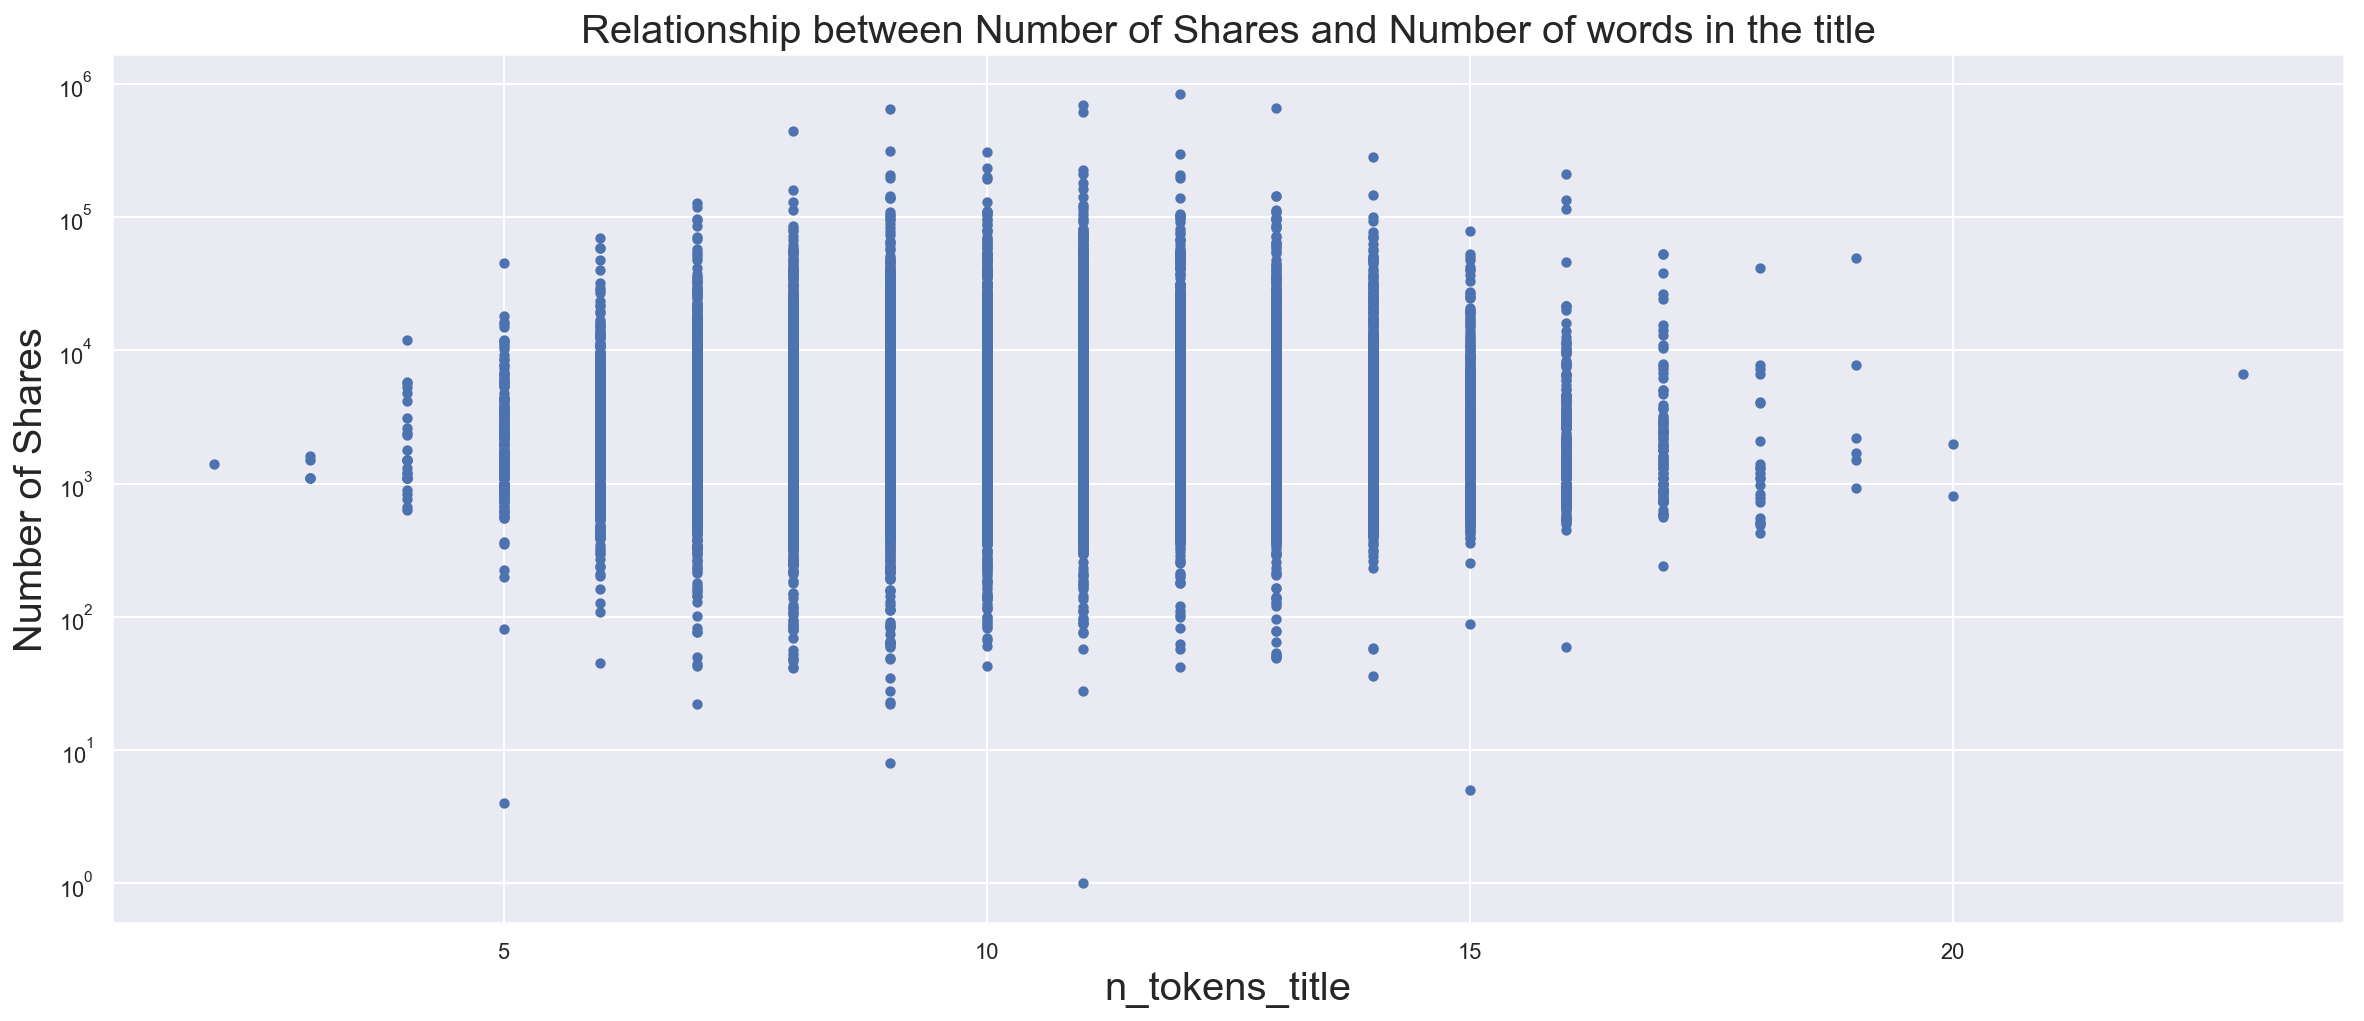

In [14]:
# non-linear correlation
non_linear_corr_vars = [
    'global_sentiment_polarity',
    'n_tokens_title', 
]

non_linear_corr_names = {
    'global_sentiment_polarity': 'Sentiment Score',
    'n_tokens_title': 'Number of words in the title'
}

for column_name in non_linear_corr_vars:
    fig = plt.figure(figsize=(20,8))
    ax = fig.gca()
    ax.set_yscale('log')
    ax.scatter(x = df[column_name], y = df['shares'], s = 10, linewidths = 2);
    ax.set_title('Relationship between {y} and {x}'.format(
        x = non_linear_corr_names[column_name], 
        y = target_name
    ), 
    fontsize = d_fontsize)
    ax.set_ylabel(target_name, fontsize = d_fontsize)
    ax.set_xlabel(column_name, fontsize = d_fontsize)
    plt.show()

<div class="alert alert-info" style="font-size:150%">Articles with 
<li>a neutral to slightly positive tone, and</li>
<li>title containing 7 to 13 words</li>
has higher share counts. </div>

<div class="alert alert-info" style="font-size:150%"><b>4. Seperate into predictors and target values</b></div>

In [15]:
df_predictors = df[[x for x in df.columns if x not in ['url', 'target_p50', 'target_p90', 'target_categories']]]
df_predictors.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731,12,219,0.663594,1.0,0.815385,4,2,1,0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,731,9,255,0.604743,1.0,0.791946,3,1,1,0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,731,9,211,0.575130,1.0,0.663866,3,1,1,0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,731,9,531,0.503788,1.0,0.665635,9,0,1,0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,731,13,1072,0.415646,1.0,0.540890,19,19,20,0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [16]:
df_targets = df[['shares', 'target_p50', 'target_p90', 'target_categories']]
df_targets.head()

,shares,target_p50,target_p90,target_categories
0,593,0,0,1
1,711,0,0,1
2,1500,1,0,3
3,1200,0,0,2
4,505,0,0,1


<div class="alert alert-info" style="font-size:150%"><b>5. Normalise the data</b></div>

In [17]:
def normalise_predictors(df, scaler_name='mms'):
    scaler = None
    if scaler_name == 'mms':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    elif scaler_name == 'rb': 
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
    return scaler.fit_transform(df)

df_mms = normalise_predictors(df_predictors, 'mms')
df_mms

array([[1.00000000e+00, 4.76190476e-01, 2.58437574e-02, ...,
        0.00000000e+00, 1.87500000e-01, 7.02004864e-04],
       [1.00000000e+00, 3.33333333e-01, 3.00920463e-02, ...,
        1.00000000e+00, 0.00000000e+00, 8.41931509e-04],
       [1.00000000e+00, 3.33333333e-01, 2.48996932e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.77754272e-03],
       ...,
       [0.00000000e+00, 3.80952381e-01, 5.21595468e-02, ...,
        9.09090909e-02, 1.36363636e-01, 2.25187033e-03],
       [0.00000000e+00, 1.90476190e-01, 8.04814727e-02, ...,
        1.00000000e+00, 0.00000000e+00, 1.30321511e-03],
       [0.00000000e+00, 3.80952381e-01, 1.85272599e-02, ...,
        3.33333333e-01, 2.50000000e-01, 1.54037892e-03]])

<div class="alert alert-info" style="font-size:150%"><b>6. Define the model functions</b></div>

In [18]:
# define the functions
def model_linear_regression(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    
    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_lasso_alpha(X, y):
    from sklearn.linear_model import LassoCV  
    ls = LassoCV(cv = 10, n_alphas = 500, random_state = 42)
    ls.fit(X, y)
    return ls.alpha_

def model_lasso(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha = get_lasso_alpha(X, y)
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import cross_val_score
    
    ls = Lasso(alpha = alpha)
    scores = cross_val_score(ls, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_ridge_alpha(X, y):
    from sklearn.linear_model import RidgeCV  
    ls = RidgeCV(alphas = np.linspace(0.1, 10, 20), cv = 10)
    ls.fit(X, y)
    return ls.alpha_

def model_ridge(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha = get_ridge_alpha(X, y)
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import cross_val_score
    
    rd = Ridge(alpha = alpha)
    scores = cross_val_score(rd, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

def get_elasticnet_alpha_l1ratio(X, y):
    from sklearn.linear_model import ElasticNetCV  
    en = ElasticNetCV(alphas = np.linspace(0.1, 10, 20), n_alphas = 20, cv = 10)
    en.fit(X, y)
    return en.alpha_, en.l1_ratio

def model_elasticnet(X, y, scaler_name):
    X = normalise_predictors(X, scaler_name)
    alpha, l1_ratio = get_elasticnet_alpha_l1ratio(X, y)
    from sklearn.linear_model import ElasticNet
    from sklearn.model_selection import cross_val_score
    
    en = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
    scores = cross_val_score(en, X, y, cv = 10)
    R2 = np.mean(scores)
    return R2

In [19]:
store_R2 = [] # scaler, number_of_predictor, model_type, R2, y_type

<div class="alert alert-info" style="font-size:150%"><b>7. Run the model for each target variable, each predictor (5, 10, all), and each normalised predictor (mms, rb)</b></div>

In [21]:
predictors = [df_predictors[predictors_t5], df_predictors[predictors_t10], df_predictors[predictors_all]]

for i in tnrange(len(predictors), desc='main loop'):
    df_temp = predictors[i]

    column_length = df_targets.shape[1]
    for column_index in tnrange(column_length, desc='2nd loop'):
        y = df_targets.iloc[:, column_index]

        r2_mms = model_ridge(df_temp, y, scaler_name='mms')
        r2_rb = model_ridge(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'ridge', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'ridge', y.name, r2_rb])

        r2_mms = model_lasso(df_temp, y, scaler_name='mms')
        r2_rb = model_lasso(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'lasso', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'lasso', y.name, r2_rb])

        r2_mms = model_elasticnet(df_temp, y, scaler_name='mms')
        r2_rb = model_elasticnet(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'elastic', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'elastic', y.name, r2_rb])

        r2_mms = model_linear_regression(df_temp, y, scaler_name='mms')
        r2_rb = model_linear_regression(df_temp, y, scaler_name='rb')
        store_R2.append(['mms', df_temp.shape[1], 'linearRegression', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'linearRegression', y.name, r2_rb])

    
print(store_R2)



[['mms', 5, 'ridge', 'shares', 0.01540010790962858], ['rb', 5, 'ridge', 'shares', 0.014925760454626147], ['mms', 5, 'lasso', 'shares', 0.015346360060087216], ['rb', 5, 'lasso', 'shares', 0.015179126691988187], ['mms', 5, 'elastic', 'shares', -0.0008518918570541101], ['rb', 5, 'elastic', 'shares', 0.015030636162159883], ['mms', 5, 'linearRegression', 'shares', 0.014923708441612482], ['rb', 5, 'linearRegression', 'shares', 0.01492370844161246], ['mms', 5, 'ridge', 'target_p50', 0.022673293456954836], ['rb', 5, 'ridge', 'target_p50', 0.02263080467938261], ['mms', 5, 'lasso', 'target_p50', 0.022660799409451548], ['rb', 5, 'lasso', 'target_p50', 0.02266144095613203], ['mms', 5, 'elastic', 'target_p50', -0.012008714931147723], ['rb', 5, 'elastic', 'target_p50', 0.0056753673867701694], ['mms', 5, 'linearRegression', 'target_p50', 0.022628263541894754], ['rb', 5, 'linearRegression', 'target_p50', 0.022628263541894577], ['mms', 5, 'ridge', 'target_p90', 0.02950263219626533], ['rb', 5, 'ridge',

In [36]:
df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head()

,ScalerType,NumPredictor,ModelType,Target,R2
90,mms,59,lasso,target_categories,0.112140
88,mms,59,ridge,target_categories,0.110415
56,mms,10,ridge,target_categories,0.097340
57,rb,10,ridge,target_categories,0.097297
62,mms,10,linearRegression,target_categories,0.097295


<div class="alert alert-info" style="font-size:150%">9. Try Random Forest, Adaptive Boosting, SVM, Neutral Network </div>

In [28]:
# import tensorflow as tf
# from tensorflow import keras - cannot use as tensorflow havent support python 3.7

In [20]:
print('test')
def model_randomForest(X, y, scaler_name):
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    X = normalise_predictors(X, scaler_name)
    rfc = RandomForestClassifier()
    results = cross_val_score(rfc, X = X, y = y, cv=10)
    return np.mean(results)

predictors = [df_predictors[predictors_t5], df_predictors[predictors_t10], df_predictors[predictors_all]]

for i in tnrange(len(predictors), desc='main loop'):
    df_temp = predictors[i]

    column_length = df_targets.shape[1]
    for column_index in tnrange(column_length, desc='2nd loop'):
        y = df_targets.iloc[:, column_index]
        
        r2_mms = model_randomForest(df_temp, y, scaler_name='mms')
        r2_rb = model_randomForest(df_temp, y, scaler_name='rb')

        store_R2.append(['mms', df_temp.shape[1], 'randomForest', y.name, r2_mms])
        store_R2.append(['rb', df_temp.shape[1], 'randomForest', y.name, r2_rb])


test


In [22]:
df_R2 = pd.DataFrame(store_R2, columns = ['ScalerType','NumPredictor','ModelType','Target','R2'])
df_R2.sort_values(by='R2', ascending=False).head(10) 

,ScalerType,NumPredictor,ModelType,Target,R2
21,rb,59,randomForest,target_p90,0.896681
20,mms,59,randomForest,target_p90,0.896428
12,mms,10,randomForest,target_p90,0.894864
13,rb,10,randomForest,target_p90,0.894789
4,mms,5,randomForest,target_p90,0.889744
5,rb,5,randomForest,target_p90,0.889466
11,rb,10,randomForest,target_p50,0.591517
10,mms,10,randomForest,target_p50,0.587128
19,rb,59,randomForest,target_p50,0.585065
18,mms,59,randomForest,target_p50,0.583502


<div class="alert alert-info" style="font-size:150%">With R2 = 0.89, Random Forest worked pretty well in predicting share count > 90th percentile using robust scaler and all 59 predictors.</div>

In [24]:
# support vector machine - not linear
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
x_tmp = normalise_predictors(df_predictors[predictors_all], 'rb')
model_svm = LinearSVC()
cross_val_score(model_svm, X = x_tmp, y = df_targets.iloc[:, 2], cv = 5)

array([0.89457755, 0.73149199, 0.86719637, 0.90047931, 0.8997225 ])

In [26]:
np.mean([0.89457755, 0.73149199, 0.86719637, 0.90047931, 0.8997225])

0.858693544

<div class="alert alert-info" style="font-size:150%">Support Vector Machine Worked pretty well too, but still not as good as random forest of R2=0.89. Thus, lets investigate randomforest with target_p90, scaler=robust and numPredictor = all 59.</div>

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_predictors[predictors_all], df_targets.iloc[:, 2], test_size=0.33, random_state=42)
X_train = normalise_predictors(X_train, 'rb')
X_test = normalise_predictors(X_test, 'rb')
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.896889092715738

In [29]:
rfc.feature_importances_

array([0.04055324, 0.03535462, 0.02823486, 0.026611  , 0.02253113,
       0.00238793, 0.02870337, 0.00292954, 0.0027492 , 0.0023613 ,
       0.02823792, 0.00264803, 0.02155975, 0.00190194, 0.00246026,
       0.02601894, 0.02571191, 0.0220984 , 0.01694558, 0.02390257,
       0.02420345, 0.01051007, 0.01814808, 0.02430113, 0.02980237,
       0.03041515, 0.01844392, 0.02904743, 0.01893354, 0.01034293,
       0.01996562, 0.02550343, 0.03054212, 0.01073633, 0.00254168,
       0.01075952, 0.02366338, 0.00214311, 0.00275412, 0.01373457,
       0.01853252, 0.01449619, 0.02669375, 0.01275153, 0.00288863,
       0.02726692, 0.00424571, 0.01992456, 0.02983462, 0.00337977,
       0.0020416 , 0.02401981, 0.01438698, 0.00274735, 0.022524  ,
       0.02413208, 0.00420913, 0.01430007, 0.01123136])

In [33]:
feature_importances_ = rfc.feature_importances_
feature_importance = {}
for index, name in enumerate(df_predictors[predictors_all]):
    feature_importance[name] = feature_importances_[index]

sorted_by_value = sorted(feature_importance.items(), key=lambda kv: kv[1], reverse=True)
sorted_by_value[:10] # these are the top 10 predictor vars

[('kw_avg_avg', 0.040553235486540454),
 ('kw_max_avg', 0.03535462346563381),
 ('LDA_04', 0.03054212332812195),
 ('LDA_03', 0.030415152092022123),
 ('LDA_00', 0.029834624959067135),
 ('LDA_01', 0.029802367162926113),
 ('average_token_length', 0.029047425348228295),
 ('LDA_02', 0.02870336966847629),
 ('global_subjectivity', 0.028237922491334465),
 ('self_reference_avg_sharess', 0.028234864317756608)]

<div class="alert alert-info" style="font-size:150%">The top 3 predictor variables are kw_avg_avg, kw_max_avg, and LDA_04</div>

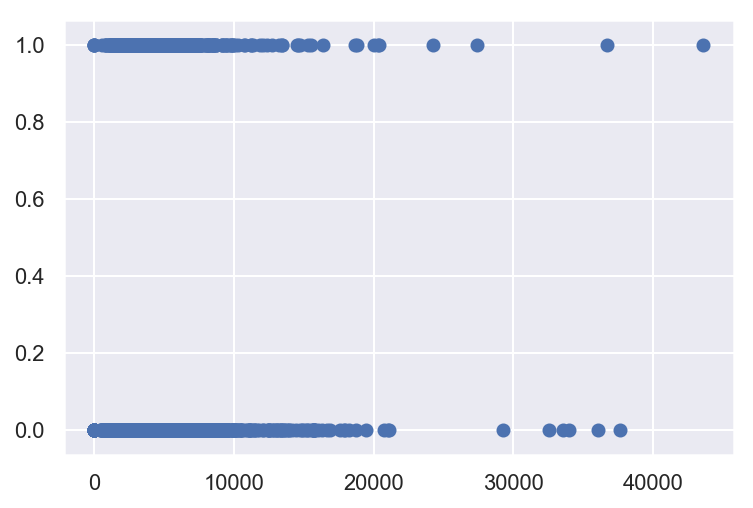

In [38]:
plt.scatter(df['kw_avg_avg'], df_targets.iloc[:, 2])

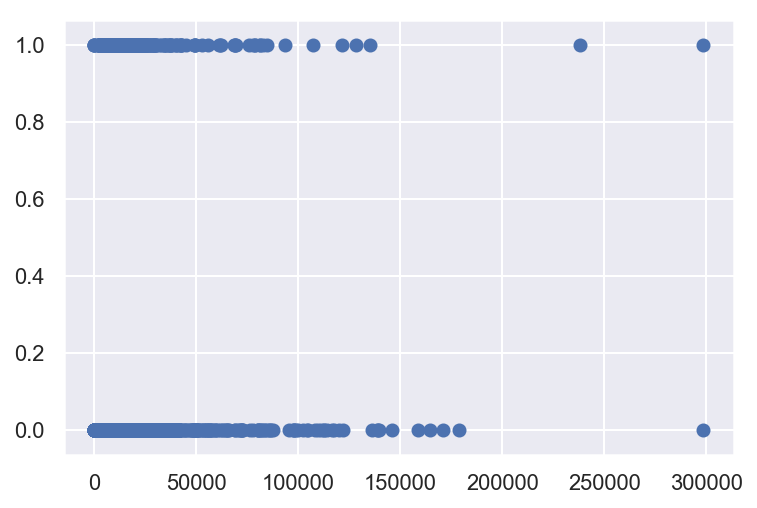

In [39]:
plt.scatter(df['kw_max_avg'], df_targets.iloc[:, 2])

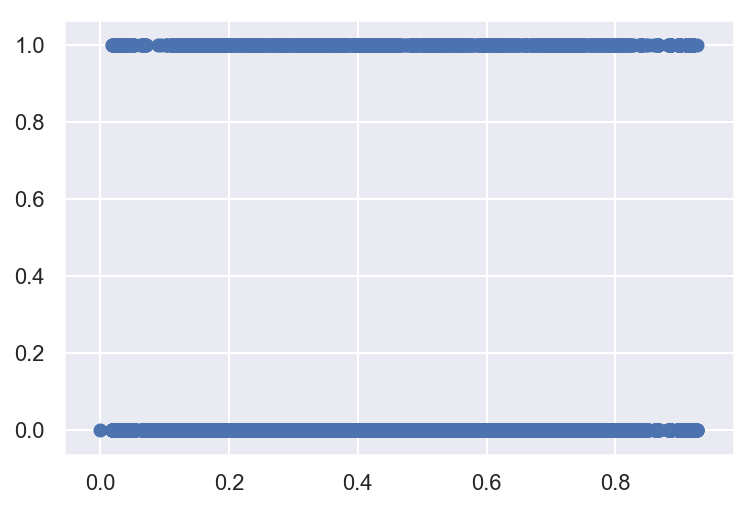

In [42]:
plt.scatter(df['LDA_04'], df_targets.iloc[:, 2])

In [63]:
# # as python 3.7 doesnt have tensorflow, lets build tensorflow our way.
# class NeuralNetwork:
#     def __init__(self, x, y):
#         self.input      = x
#         self.weights1   = np.random.rand(x.shape[1],4) 
#         self.weights2   = np.random.rand(4,1)                 
#         self.y          = y
#         self.output     = np.zeros(self.y.shape)

#     def feedforward(self):
#         def sigmoid(x):
#             x = x.astype(float)
#             print(x.dtype)
#             import numpy as np
#             s = 1/(1+np.exp(-x))
#             return s
#         self.layer1 = sigmoid(np.dot(self.input, self.weights1))
#         self.output = sigmoid(np.dot(self.layer1, self.weights2))

#     def backprop(self):
#         def sigmoid(x):
#             import numpy as np
#             s = 1/(1+np.exp(-x))
#             return s
        
#         def sigmoid_derivative(x):
#             return sigmoid(x)*(1-sigmoid(x))
        
#         # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
#         d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
#         d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))

#         # update the weights with the derivative (slope) of the loss function
#         self.weights1 += d_weights1
#         self.weights2 += d_weights2
        
# # testing
# # nn = NeuralNetwork(pd.DataFrame([[0,0,1], [0,1,1],[1,0,1], [1,1,1]]), pd.DataFrame([0,1,1,0])) # test 
# # for i in range(5000):
# #     nn.feedforward()
# #     nn.backprop()
# # print(nn.output, nn.y)

# model_nn = NeuralNetwork(df_predictors[predictors_all], df_targets.iloc[:, 2])
# for i in range(5000):
#     model_nn.feedforward()
#     model_nn.backprop()
# print(model_nn.output, model_nn.y)

float64
float64


Exception: Data must be 1-dimensional

In [32]:
# # what are the variables that caused the prediction?
# # pd.DataFrame([(predictor_vars), rfc.feature_importances_])
# feature_importances_ = rfc.feature_importances_
# feature_importance = {}
# for index, name in enumerate(predictor_vars):
#     feature_importance[name] = feature_importances_[index]

# sorted_by_value = sorted(feature_importance.items(), key=lambda kv: kv[1], reverse=True)
# sorted_by_value[:10] # these are the top 10 predictor vars
# '''
# [('kw_avg_avg', 0.041648549925375644),
#  ('kw_max_avg', 0.03796269752791201),
#  ('self_reference_min_shares', 0.03209670590593529),
#  ('LDA_02', 0.03192396892278292),
#  ('timedelta', 0.031153999073768902),
#  ('LDA_04', 0.02864868771040057),
#  ('n_non_stop_unique_tokens', 0.027772663068285852),
#  ('kw_avg_max', 0.027608267341882365),
#  ('n_unique_tokens', 0.027595845841238382),
#  ('LDA_03', 0.027371986619792055)]
#  '''

In [33]:
# Random Forest on share_category
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# not_predictors = ['shares', 'url', 'pop_above_median', 'shares_cat', 'predicted', 'pop_above_75_percentile']
# predictor_vars = [x for x in df.columns if x not in not_predictors]
# rfc = RandomForestClassifier()
# results = cross_val_score(rfc, X = df[predictor_vars], y = df['shares_cat'], cv=10)
# results # results are much worse if there are more categories
# array([0.25895108, 0.2491175 , 0.31710394, 0.33526741, 0.32088799,
#        0.33224016, 0.33249243, 0.3413219 , 0.3327447 , 0.30978809])

In [34]:
# Random Forest on pop_above_75_percentile
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
not_predictors = ['shares', 'url', 'pop_above_median', 'shares_cat', 'predicted', 'pop_above_75_percentile']
predictor_vars = [x for x in df.columns if x not in not_predictors]
rfc = RandomForestClassifier()
results = cross_val_score(rfc, X = df[predictor_vars], y = df['pop_above_75_percentile'], cv=10)
results # results are much worse if there are more categories

KeyError: 'pop_above_75_percentile'

In [ ]:
rfc.fit(df[predictor_vars], df['pop_above_75_percentile'])
feature_importances = rfc.feature_importances_

In [ ]:

sorted_by_value = sorted(feature_importance.items(), key=lambda kv: kv[1], reverse=True)
sorted_by_value[:10] # these are the top 10 predictor vars

In [ ]:
df['kw_avg_avg']